In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import grid_evaluate
from sklearn.neural_network import MLPClassifier


#Load the saved CSVs
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

#Define the base model
base_clf = MLPClassifier(
    max_iter=1000,
    random_state=42
)


param_grid = {

    'hidden_layer_sizes': [(15,), (20,), (15,15)],
    'activation':         ['relu', 'tanh'],
    'alpha':              [1e-4, 1e-3], #L2 penalty (weight decay)
    'learning_rate_init': [1e-3, 1e-2],
}


results_nn = grid_evaluate(
    estimator  = base_clf,
    param_grid = param_grid,
    X_train    = X_train,
    X_test     = X_test,
    y_train    = y_train,
    y_test     = y_test
)

#Inspect best model by F1
best_nn = results_nn.sort_values('f1_score', ascending=False)
print(best_nn.iloc[0])
print(best_nn)


c:\Users\Vai.Mathi\Downloads\ML-Final-Project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Vai.Mathi\Downloads\ML-Final-Project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Vai.Mathi\Downloads\ML-Final-Project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Vai.Mathi\Downloads\ML-Final-Project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_percept

feature_method            None
degree                    None
n_components              None
gamma                     None
accuracy                 0.724
precision             0.440678
recall                0.419355
f1_score              0.429752
activation                relu
alpha                    0.001
hidden_layer_sizes    (15, 15)
learning_rate_init        0.01
Name: 11, dtype: object
   feature_method degree n_components gamma  accuracy  precision    recall  \
11           None   None         None  None     0.724   0.440678  0.419355   
1            None   None         None  None     0.720   0.431034  0.403226   
15           None   None         None  None     0.696   0.393939  0.419355   
19           None   None         None  None     0.676   0.366197  0.419355   
21           None   None         None  None     0.688   0.378788  0.403226   
12           None   None         None  None     0.736   0.456522  0.338710   
18           None   None         None  None     0.736   0.

c:\Users\Vai.Mathi\Downloads\ML-Final-Project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Vai.Mathi\Downloads\ML-Final-Project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


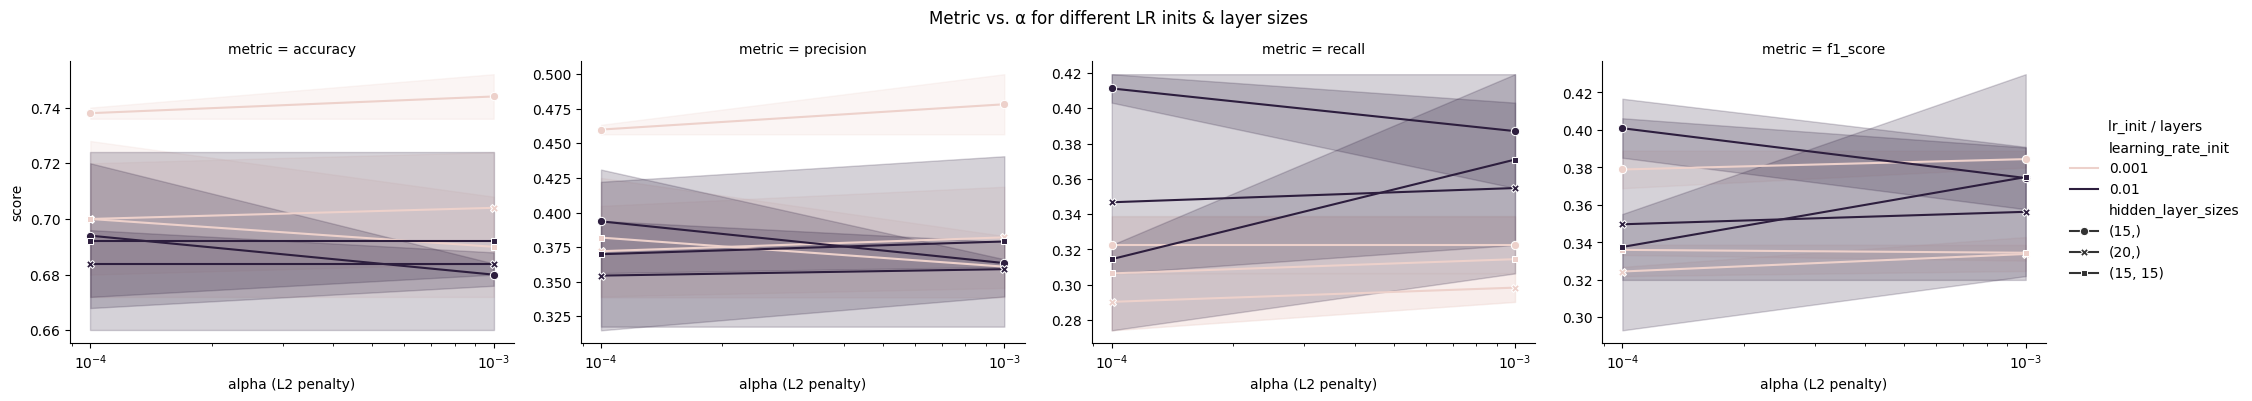

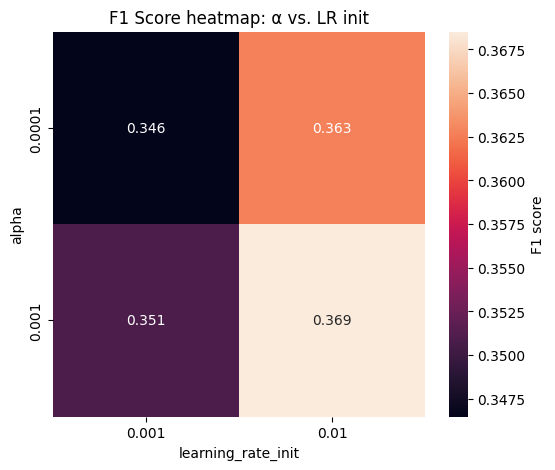

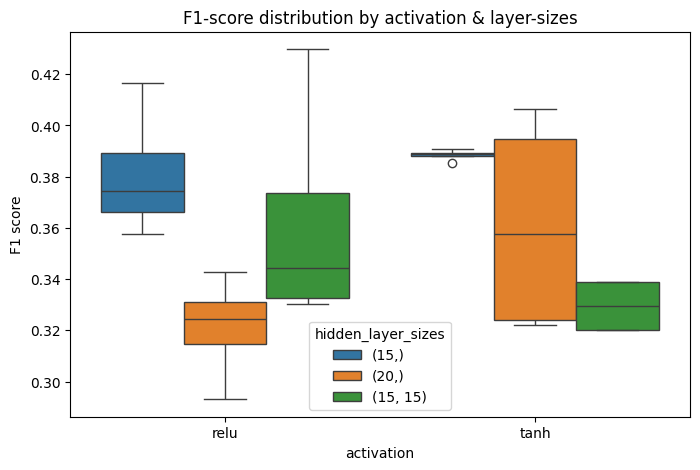

In [ ]:

df = results_nn.reset_index(drop=True)


#melting df for easier plotting
metrics = ['accuracy','precision','recall','f1_score']
df_long = df.melt(
    id_vars=['hidden_layer_sizes','activation','alpha','learning_rate_init'],
    value_vars=metrics,
    var_name='metric',
    value_name='score'
)

#using sns to visualize the results
g = sns.FacetGrid(
    df_long, 
    col='metric', 
    sharey=False, 
    height=4, 
    aspect=1.3
)

g.map_dataframe(
    sns.lineplot,
    x='alpha', 
    y='score',
    hue='learning_rate_init',
    style='hidden_layer_sizes',
    markers=True,
    dashes=False
)

g.set(xscale='log') #log scale to visualize alpha better
g.add_legend(title='lr_init / layers')
g.set_axis_labels('alpha (L2 penalty)','score')
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Metric vs. α for different LR inits & layer sizes')
plt.show()


#heatmap of F1-score over (alpha, learning_rate_init)

pivot_f1 = df.pivot_table(
    index='alpha', 
    columns='learning_rate_init', 
    values='f1_score'
)

plt.figure(figsize=(6,5))
sns.heatmap(
    pivot_f1, 
    annot=True, 
    fmt=".3f", 
    cbar_kws={'label':'F1 score'}
)
plt.title('F1 Score heatmap: α vs. LR init')
plt.xlabel('learning_rate_init')
plt.ylabel('alpha')
plt.show()


#activation comparison
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df_long[df_long.metric=='f1_score'],
    x='activation',
    y='score',
    hue='hidden_layer_sizes'
)
plt.title('F1-score distribution by activation & layer-sizes')
plt.ylabel('F1 score')
plt.show()
